In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [5]:
#Download the dataset
dataframe=pd.read_csv('data/ecg.csv',header=None)
raw_data=dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [6]:
labels=raw_data[:,-1]

data=raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2,random_state=21)

In [7]:
min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)#https://blog.csdn.net/nanhuaibeian/article/details/100591478?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromBaidu-1.not_use_machine_learn_pai&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromBaidu-1.not_use_machine_learn_pai
train_data=(train_data-min_val)/(max_val-min_val)
test_data=(test_data-min_val)/(max_val-min_val)
train_data=tf.cast(train_data,tf.float32)
test_data=tf.cast(test_data,tf.float32)
test_data.dtype

Metal device set to: Apple M1 Pro


2022-10-09 11:05:34.879017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-09 11:05:34.879494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tf.float32

In [8]:
trian_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

normal_train_data = train_data[train_labels==True]
normal_test_data = test_data[test_labels==True]

anomalous_train_data = train_data[train_labels==False]
anomalous_test_data = test_data[test_labels==False]
normal_test_data

<tf.Tensor: shape=(560, 140), dtype=float32, numpy=
array([[0.48035768, 0.28877792, 0.19828546, ..., 0.45463306, 0.5246125 ,
        0.3713729 ],
       [0.45354807, 0.2557325 , 0.15979648, ..., 0.4801337 , 0.5284734 ,
        0.49527124],
       [0.4521779 , 0.25685105, 0.12592098, ..., 0.55448556, 0.5861353 ,
        0.4754273 ],
       ...,
       [0.48304972, 0.36122933, 0.27729514, ..., 0.32799056, 0.3158066 ,
        0.26930442],
       [0.4090865 , 0.27907097, 0.22604261, ..., 0.39099607, 0.45987615,
        0.42140076],
       [0.42648116, 0.17669384, 0.14546008, ..., 0.4733389 , 0.55036914,
        0.37805188]], dtype=float32)>

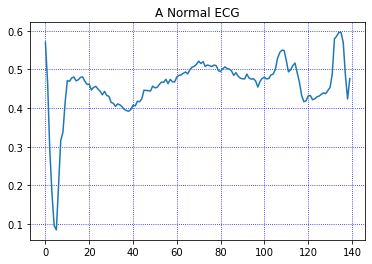

In [9]:
#normal ECG
plt.grid(linestyle=":",color="b")
plt.plot(np.arange(140),normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

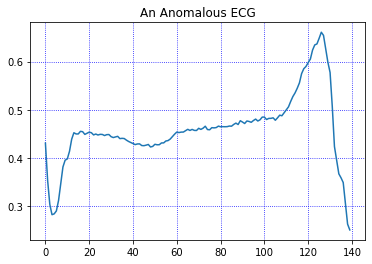

In [10]:
#anomal ECG
plt.grid(linestyle=":",color="b")
plt.plot(np.arange(140),anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [11]:
##model
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder=tf.keras.Sequential([layers.Dense(32,activation="relu"),layers.Dense(16,activation="relu"),layers.Dense(8,activation="relu")])
        self.decoder=tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])
    def call(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(x)
        return decoded
autoencoder=AnomalyDetector()
autoencoder.compile(optimizer='adam',loss='mae')

In [12]:

history=autoencoder.fit(normal_train_data,normal_train_data,epochs=20,batch_size=512,
                       validation_data=(test_data,test_data),shuffle=True)

Epoch 1/20


2022-10-09 11:06:11.666098: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2022-10-09 11:06:11.958808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 50ms/step - loss: 0.0656 - val_loss: 0.0573
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0574 - val_loss: 0.0530
Epoch 3/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0542 - val_loss: 0.0511
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0518 - val_loss: 0.0497
Epoch 5/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0499

2022-10-09 11:06:12.643117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 8ms/step - loss: 0.0491 - val_loss: 0.0482
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0459 - val_loss: 0.0466
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0426 - val_loss: 0.0452
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0395 - val_loss: 0.0437
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0364 - val_loss: 0.0419
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0335 - val_loss: 0.0403
Epoch 11/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0312 - val_loss: 0.0392
Epoch 12/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0380
Epoch 13/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0276 - val_loss: 0.0372
Epoch 14/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0261 - val_loss: 0.0364
Epoch 15/20
5/5 [=============================

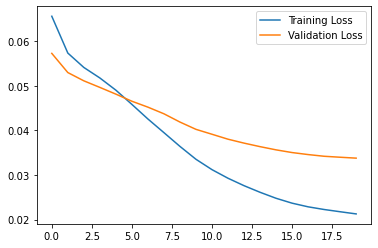

In [13]:
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()

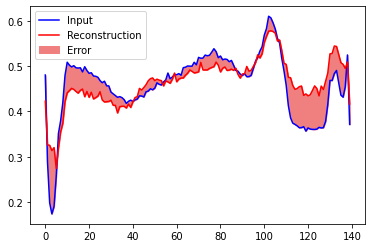

array([[0.2555583 , 0.        , 0.09528635, ..., 0.3557812 , 0.1657536 ,
        0.06648298],
       [0.23585561, 0.        , 0.10561839, ..., 0.39087993, 0.13874952,
        0.03694454],
       [0.25422245, 0.        , 0.10345703, ..., 0.4265148 , 0.18697335,
        0.08491793],
       ...,
       [0.2238874 , 0.        , 0.1244058 , ..., 0.4330535 , 0.21985236,
        0.12493309],
       [0.21668261, 0.        , 0.12037995, ..., 0.39924523, 0.13873115,
        0.0411683 ],
       [0.2161204 , 0.        , 0.12168553, ..., 0.38597968, 0.15462941,
        0.03810754]], dtype=float32)

In [138]:
encoded_imgs=autoencoder.encoder(normal_test_data).numpy()
decoded_imgs=autoencoder.decoder(normal_test_data).numpy()
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140),decoded_imgs[0],normal_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()
encoded_imgs

In [146]:
encoded_imgs=autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs=autoencoder.decoder(anomalous_test_data).numpy()

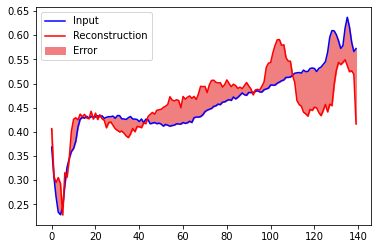

In [147]:
plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140),decoded_imgs[0],anomalous_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

In [201]:
reconstructions=autoencoder.predict(normal_train_data)#predict为输入样本生成输出预测，样本属于每个类别的概率，这里是0（异常），1（正常）。计算是分批进行的，返回预测的 Numpy 数组（或数组列表）。
reconstructions

array([[0.41380453, 0.3153438 , 0.3074426 , ..., 0.5145064 , 0.5152197 ,
        0.4169959 ],
       [0.41241598, 0.31415835, 0.30778798, ..., 0.5082562 , 0.5146942 ,
        0.41524723],
       [0.40812522, 0.3083728 , 0.29826844, ..., 0.51941544, 0.5178381 ,
        0.41540617],
       ...,
       [0.4131756 , 0.31389993, 0.30685532, ..., 0.51212585, 0.5150769 ,
        0.41600072],
       [0.41207662, 0.31165403, 0.30362058, ..., 0.51571447, 0.5159343 ,
        0.41583717],
       [0.41148973, 0.31259212, 0.30476916, ..., 0.5128152 , 0.51558566,
        0.41540223]], dtype=float32)

In [202]:
train_loss=tf.keras.losses.mae(reconstructions,normal_train_data).numpy()
train_loss

array([0.0289216 , 0.01321632, 0.02052343, ..., 0.01408088, 0.02460689,
       0.01808788], dtype=float32)

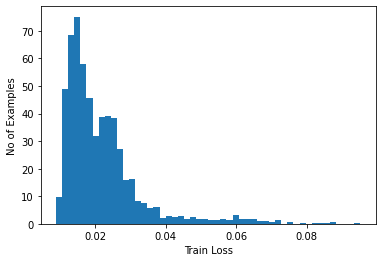

In [203]:
plt.hist(train_loss,bins=50,density=True)#直方图
plt.xlabel("Train Loss")
plt.ylabel("No of Examples")
plt.show()

In [204]:
#选择比平均值高一个标准偏差的阈值。这里选择阈值的方法取决于数据集。
threshold=np.mean(train_loss)+np.std(train_loss)
print("Threshold",threshold)

Threshold 0.032959238


In [205]:
#当检测测试集中的异常样本的重构误差的时候，大部分样本的重构误差会比阈值大很多，
#通过改变阈值可以的调整分类器的精准率和召回率
reconstructions=autoencoder.predict(anomalous_test_data)
reconstructions

array([[0.40688264, 0.30828443, 0.29523492, ..., 0.5267016 , 0.5191071 ,
        0.41661417],
       [0.4182523 , 0.32958204, 0.32941368, ..., 0.48170316, 0.5082155 ,
        0.4146314 ],
       [0.41970825, 0.32497528, 0.3255919 , ..., 0.4859928 , 0.50842375,
        0.4133119 ],
       ...,
       [0.42013764, 0.32541203, 0.32556605, ..., 0.48734376, 0.50829875,
        0.41360122],
       [0.41686746, 0.33152017, 0.33023095, ..., 0.48259863, 0.5094029 ,
        0.41687724],
       [0.40550542, 0.32110286, 0.3097554 , ..., 0.50840825, 0.518119  ,
        0.41905764]], dtype=float32)

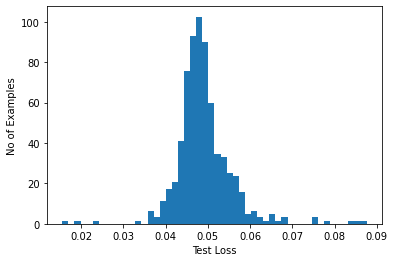

In [206]:
test_loss=tf.keras.losses.mae(reconstructions,anomalous_test_data).numpy()
plt.hist(test_loss,bins=50,density=True)
plt.xlabel("Test Loss")
plt.ylabel("No of Examples")
plt.show()

In [211]:
#如果异构误差大于阈值那么将这个ECG分类为异常
def predict(model,data,threshold):
    reconstructions=model(data)
    loss=tf.keras.losses.mae(reconstructions,data)
    return tf.math.less(loss,threshold)#返回loss小于threshold的真值
def print_stats(prediction,labels):
    print("Accuracy={}".format(accuracy_score(labels,preds)))
    print("Precision={}".format(precision_score(labels,preds)))
    print("Recall={}".format(recall_score(labels,preds)))

In [212]:
preds=predict(autoencoder,test_data,threshold)
print_stats(preds,test_labels)

Accuracy=0.943
Precision=0.9941060903732809
Recall=0.9035714285714286
